In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

from hp_pred.experiments import objective_xgboost, bootstrap_test, create_balanced_cv

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [13]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 60*5]

FEATURE_NAME = (
    [
        f"{signal}_ema_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)

BASELINE_FEATURE_NAME = 'mbp_ema_10'

## Load and format data

In [14]:
# import the data frame and add the meta data to the segments
data = pd.read_parquet(Path('data/datasets/base_dataset_no_leading_time/cases/'))

static = pd.read_parquet('data/datasets/base_dataset_no_leading_time/meta.parquet')

data = data.merge(static, on='caseid')

data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)



## Train or load existing model


In [15]:
# control reproducibility
rng_seed = 42

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / f"xgb.json"

# create a regressor
if model_file.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_file)
else:
    ImportError("Model file does not exist, run the xgboost study first")

for leading_time in range(0,7,2):
    data_lead = data[(data.time_before_IOH >= leading_time*60) | (data.time_before_IOH.isna())]

    test = data_lead[data_lead['split'] == "test"].copy()

    test.label_id = test.label_id.astype(str) + test.caseid.astype(str)

    test = test.dropna(subset=FEATURE_NAME)
    print('leading time:', leading_time)
    print(
        f'{len(test)} test samples, positive rate = {test["label"].mean():.2f}'
    )


    # test the model
    y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
    y_test = test["label"].values
    y_label_id = test["label_id"].values

    df_results, _ = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results.to_csv(roc_results, index=False)

    # test baseline
    y_pred_baseline = 1 - test[BASELINE_FEATURE_NAME].values/120

    df_results_baseline, _ = bootstrap_test(y_test, y_pred_baseline, y_label_id, n_bootstraps=200, rng_seed=rng_seed)

    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results_baseline.to_csv(roc_results, index=False)




leading time: 0
40545 test samples, positive rate = 0.07
leading time: 2
39882 test samples, positive rate = 0.06
leading time: 4
39257 test samples, positive rate = 0.04
leading time: 6
38704 test samples, positive rate = 0.03


## Plot

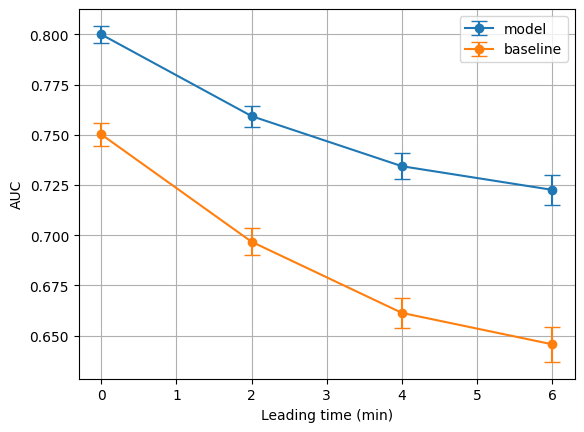

In [16]:
xgboost_auc_list, baseline_auc_list, lead_time_list = [], [], []
xgboost_auc_std_list, baseline_auc_std_list = [], []
xgboost_ioh_sensitivity_list, baseline_ioh_sensitivity_list = [], []
xgboost_ioh_sensitivity_list_std, baseline_ioh_sensitivity_list_std = [], []

for leading_time in range(0,7,2):
    lead_time_list.append(leading_time)
    roc_results = result_folder / f"xgboost_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    xgboost_auc_list.append(df_results.auc[0])
    xgboost_auc_std_list.append(df_results.auc_std[0])
    xgboost_ioh_sensitivity_list.append(df_results.ioh_sensitivity[0]*100)
    xgboost_ioh_sensitivity_list_std.append(df_results.ioh_sensitivity_std[0]*100)


    roc_results = result_folder / f"baseline_roc_lead_{leading_time}.csv"
    df_results = pd.read_csv(roc_results)
    baseline_auc_list.append(df_results.auc[0])
    baseline_auc_std_list.append(df_results.auc_std[0])
    baseline_ioh_sensitivity_list.append(df_results.ioh_sensitivity[0]*100)
    baseline_ioh_sensitivity_list_std.append(df_results.ioh_sensitivity_std[0]*100)
    

plt.errorbar(lead_time_list, xgboost_auc_list,xgboost_auc_std_list, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_auc_list, baseline_auc_std_list, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('AUC')
plt.grid()
plt.legend()
plt.show()

#save the data
auc_df = pd.DataFrame({'lead_time': lead_time_list, 'xgboost_auc': xgboost_auc_list, 'xgboost_auc_std': xgboost_auc_std_list, 'baseline_auc': baseline_auc_list, 'baseline_auc_std': baseline_auc_std_list})
auc_df.to_csv(result_folder / 'auc_lead_time.csv', index=False)

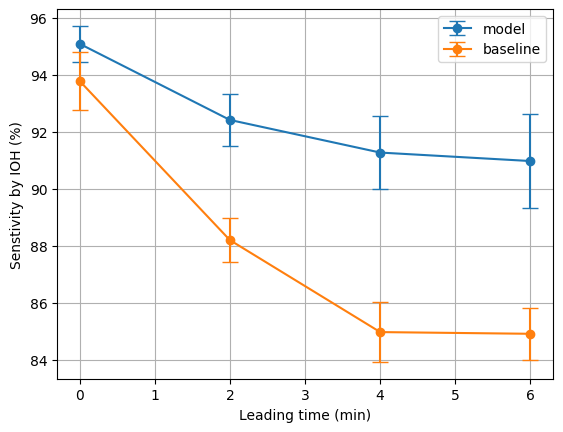

In [17]:
plt.errorbar(lead_time_list, xgboost_ioh_sensitivity_list,xgboost_ioh_sensitivity_list_std, fmt='-o', label='model', capsize=6)
plt.errorbar(lead_time_list, baseline_ioh_sensitivity_list, baseline_ioh_sensitivity_list_std, fmt='-o', label='baseline', capsize=6)
plt.xlabel('Leading time (min)')
plt.ylabel('Senstivity by IOH (%)')
plt.grid()
plt.legend()
plt.show()